In [0]:
%tensorflow_version 1.x
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
import tensorflow as tf
from progressbar import progressbar
from google.colab import files
import imageio
tflib.init_tf()

# Get necessary files

In [1]:
!git clone https://github.com/huydang90/AI-Dreaming-with-Generate-Art.git

Cloning into 'AI-Dreaming-with-Generate-Art'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 101 (delta 12), reused 87 (delta 6), pack-reused 0
Receiving objects: 100% (101/101), 11.69 MiB | 4.17 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [4]:
%cd /content/AI-Dreaming-with-Generate-Art/stylegan2

/content/AI-Dreaming-with-Generate-Art/stylegan2


In [29]:
#Get the trained model weights file
!gdown --id 1KnRD7e9g6iJCYgHRfMyiCFScjlFT-lFo --output Gs_1024

with open("Gs_1024","rb") as f:
  Gs = pickle.load(f)


Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


#Upload and process audio

In [17]:
#Upload audio (mp3 format)

uploaded = files.upload()

Saving Travel Around Stars.mp3 to Travel Around Stars.mp3


In [25]:
#Get duration of mp3
!pip install mutagen
import mutagen
from mutagen.mp3 import MP3

#Get name of uploaded file
for fn in uploaded.keys():
  name = fn
type(name)

audiopath=name
audio = MP3(name)
audio_info = audio.info    
length_in_secs = int(audio_info.length)

print(f'User uploaded file "{name}" with length {length_in_secs} seconds')

User uploaded file "Travel Around Stars.mp3" with length 293 seconds


#Generate video

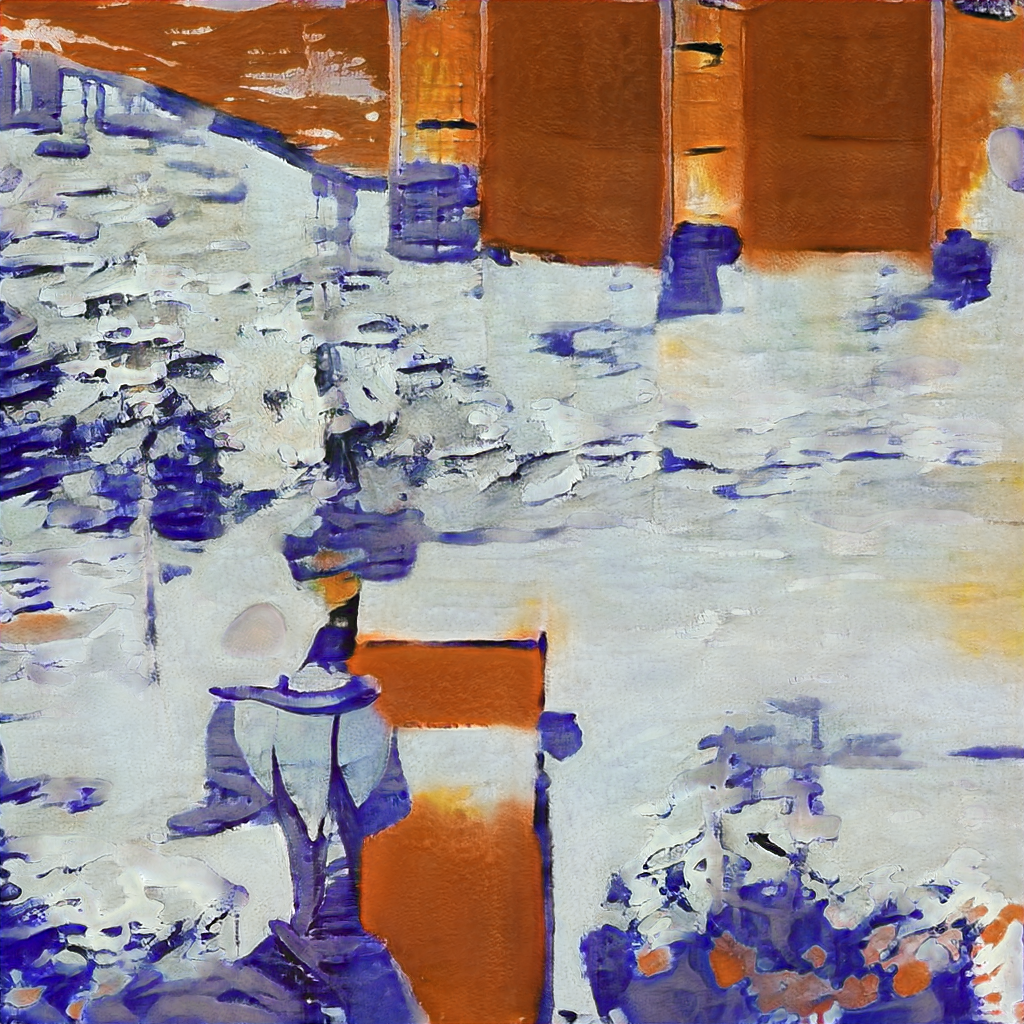

In [37]:
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)

#Get random images 
import random
rnd = np.random.RandomState(random.randint(1,1000000))

#rerun this line to get a different image
#LATENT_SPACE_SCALE = 35.
LATENT_SPACE_SCALE = 10.
latent_vector = rnd.randn(1, Gs.input_shape[1]) * LATENT_SPACE_SCALE

images = Gs.run(latent_vector, None, truncation_psi=1, randomize_noise=False, output_transform=fmt)
PIL.Image.fromarray(images[0])

In [0]:
def linear_morph(old_latent_vector, Gs, writer):
  ''' 
  Morphs a vector in the latent space linearly into some other random vector.
  The is picked so that the speed is reasonable. Feel free to play with it.
  Returns the morphed vector.
  '''
  new_latent_vector = rnd.randn(1, old_latent_vector.size) * LATENT_SPACE_SCALE

  for k in progressbar(np.arange(0., 1., 0.005)):
    latent_vector = old_latent_vector * (1. - k) + new_latent_vector * k
    images = Gs.run(latent_vector, None, truncation_psi=1, 
                    randomize_noise=False, output_transform=fmt)
    PIL.Image.fromarray(images[0])
    writer.append_data(images[0])
  
  return new_latent_vector


def piecewise_linear_morph(latent_vector, Gs, writer, num_morphs):
  '''
  Makes num_morphs of linear morphs. 
  '''
  for i in range(num_morphs):
    latent_vector = linear_morph(latent_vector, Gs, writer)

In [0]:
videopath = 'morphing_paintings.mp4'
writer = imageio.get_writer(videopath, fps=30)

num_morphs = int(length_in_secs / 5)

piecewise_linear_morph(latent_vector, Gs, writer, num_morphs=num_morphs)

writer.close()

100% (200 of 200) |######################| Elapsed Time: 0:00:37 Time:  0:00:37
100% (200 of 200) |######################| Elapsed Time: 0:00:35 Time:  0:00:35
100% (200 of 200) |######################| Elapsed Time: 0:00:36 Time:  0:00:36
100% (200 of 200) |######################| Elapsed Time: 0:00:40 Time:  0:00:40
100% (200 of 200) |######################| Elapsed Time: 0:00:38 Time:  0:00:38
100% (200 of 200) |######################| Elapsed Time: 0:00:37 Time:  0:00:37
100% (200 of 200) |######################| Elapsed Time: 0:00:36 Time:  0:00:36
100% (200 of 200) |######################| Elapsed Time: 0:00:37 Time:  0:00:37
100% (200 of 200) |######################| Elapsed Time: 0:00:38 Time:  0:00:38
100% (200 of 200) |######################| Elapsed Time: 0:00:36 Time:  0:00:36
100% (200 of 200) |######################| Elapsed Time: 0:00:35 Time:  0:00:35
100% (200 of 200) |######################| Elapsed Time: 0:00:34 Time:  0:00:34
100% (200 of 200) |#####################

# Combine video and audio

In [0]:
# combine video and mp3
def combine_audio(vidname, audname, outname, fps=30):
    import moviepy.editor as mpe
    my_clip = mpe.VideoFileClip(vidname)
    audio_background = mpe.AudioFileClip(audname)
    final_clip = my_clip.set_audio(audio_background)
    final_clip.write_videofile(outname,fps=fps)
audiopath = name
outname = "morphing_paintings_combined.mp4"
combine_audio(videopath, audiopath, outname)

In [0]:
#Cut video to length of audio 
from moviepy.editor import VideoFileClip

# clip = VideoFileClip("sample.mp4").subclip(start, end)
clip = VideoFileClip("morphing_paintings_final.mp4").subclip(0, length_in_secs)

In [0]:
files.download("morphing_paintings_final.mp4")

# Copy file to Gdrive

In [0]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/stylegan2/morphing_paintings_final.mp4 '/content/gdrive/My Drive'

#Create widget for generated painting sampling

In [0]:
import ipywidgets as widgets
import pretrained_networks
import PIL.Image
import numpy as np
# network_pkl = 'network-snapshot-006746.pkl'
# _G, _D, Gs = pretrained_networks.load_networks(network_pkl)
import dnnlib
import dnnlib.tflib as tflib
Gs_syn_kwargs = dnnlib.EasyDict()
batch_size = 1
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = True
Gs_syn_kwargs.minibatch_size = batch_size

In [0]:
artist = widgets.Dropdown(
    options=[('Unknown Artist', 0), ('Boris Kustodiev', 1), ('Camille Pissarro', 2), ('Childe Hassam', 3), ('Claude Monet', 4), ('Edgar Degas', 5), ('Eugene Boudin', 6), ('Gustave Dore', 7), ('Ilya Repin', 8), ('Ivan Aivazovsky', 9), ('Ivan Shishkin', 10), ('John Singer Sargent', 11), ('Marc Chagall', 12), ('Martiros Saryan', 13), ('Nicholas Roerich', 14), ('Pablo Picasso', 15), ('Paul Cezanne', 16), ('Pierre Auguste Renoir', 17), ('Pyotr Konchalovsky', 18), ('Raphael Kirchner', 19), ('Rembrandt', 20), ('Salvador Dali', 21), ('Vincent Van Gogh', 22), ('Hieronymus Bosch', 23), ('Leonardo Da Vinci', 24), ('Albrecht Durer', 25), ('Edouard Cortes', 26), ('Sam Francis', 27), ('Juan Gris', 28), ('Lucas Cranach The Elder', 29), ('Paul Gauguin', 30), ('Konstantin Makovsky', 31), ('Egon Schiele', 32), ('Thomas Eakins', 33), ('Gustave Moreau', 34), ('Francisco Goya', 35), ('Edvard Munch', 36), ('Henri Matisse', 37), ('Fra Angelico', 38), ('Maxime Maufra', 39), ('Jan Matejko', 40), ('Mstislav Dobuzhinsky', 41), ('Alfred Sisley', 42), ('Mary Cassatt', 43), ('Gustave Loiseau', 44), ('Fernando Botero', 45), ('Zinaida Serebriakova', 46), ('Georges Seurat', 47), ('Isaac Levitan', 48), ('Joaquã­n Sorolla', 49), ('Jacek Malczewski', 50), ('Berthe Morisot', 51), ('Andy Warhol', 52), ('Arkhip Kuindzhi', 53), ('Niko Pirosmani', 54), ('James Tissot', 55), ('Vasily Polenov', 56), ('Valentin Serov', 57), ('Pietro Perugino', 58), ('Pierre Bonnard', 59), ('Ferdinand Hodler', 60), ('Bartolome Esteban Murillo', 61), ('Giovanni Boldini', 62), ('Henri Martin', 63), ('Gustav Klimt', 64), ('Vasily Perov', 65), ('Odilon Redon', 66), ('Tintoretto', 67), ('Gene Davis', 68), ('Raphael', 69), ('John Henry Twachtman', 70), ('Henri De Toulouse Lautrec', 71), ('Antoine Blanchard', 72), ('David Burliuk', 73), ('Camille Corot', 74), ('Konstantin Korovin', 75), ('Ivan Bilibin', 76), ('Titian', 77), ('Maurice Prendergast', 78), ('Edouard Manet', 79), ('Peter Paul Rubens', 80), ('Aubrey Beardsley', 81), ('Paolo Veronese', 82), ('Joshua Reynolds', 83), ('Kuzma Petrov Vodkin', 84), ('Gustave Caillebotte', 85), ('Lucian Freud', 86), ('Michelangelo', 87), ('Dante Gabriel Rossetti', 88), ('Felix Vallotton', 89), ('Nikolay Bogdanov Belsky', 90), ('Georges Braque', 91), ('Vasily Surikov', 92), ('Fernand Leger', 93), ('Konstantin Somov', 94), ('Katsushika Hokusai', 95), ('Sir Lawrence Alma Tadema', 96), ('Vasily Vereshchagin', 97), ('Ernst Ludwig Kirchner', 98), ('Mikhail Vrubel', 99), ('Orest Kiprensky', 100), ('William Merritt Chase', 101), ('Aleksey Savrasov', 102), ('Hans Memling', 103), ('Amedeo Modigliani', 104), ('Ivan Kramskoy', 105), ('Utagawa Kuniyoshi', 106), ('Gustave Courbet', 107), ('William Turner', 108), ('Theo Van Rysselberghe', 109), ('Joseph Wright', 110), ('Edward Burne Jones', 111), ('Koloman Moser', 112), ('Viktor Vasnetsov', 113), ('Anthony Van Dyck', 114), ('Raoul Dufy', 115), ('Frans Hals', 116), ('Hans Holbein The Younger', 117), ('Ilya Mashkov', 118), ('Henri Fantin Latour', 119), ('M.C. Escher', 120), ('El Greco', 121), ('Mikalojus Ciurlionis', 122), ('James Mcneill Whistler', 123), ('Karl Bryullov', 124), ('Jacob Jordaens', 125), ('Thomas Gainsborough', 126), ('Eugene Delacroix', 127), ('Canaletto', 128)],
    value=0,
    description='Artist: '
)
genre = widgets.Dropdown(
    options=[('Abstract Painting', 129), ('Cityscape', 130), ('Genre Painting', 131), ('Illustration', 132), ('Landscape', 133), ('Nude Painting', 134), ('Portrait', 135), ('Religious Painting', 136), ('Sketch And Study', 137), ('Still Life', 138), ('Unknown Genre', 139)],
    value=139,
    description='Genre: '
)
style = widgets.Dropdown(
    options=[('Abstract Expressionism', 140), ('Action Painting', 141), ('Analytical Cubism', 142), ('Art Nouveau', 143), ('Baroque', 144), ('Color Field Painting', 145), ('Contemporary Realism', 146), ('Cubism', 147), ('Early Renaissance', 148), ('Expressionism', 149), ('Fauvism', 150), ('High Renaissance', 151), ('Impressionism', 152), ('Mannerism Late Renaissance', 153), ('Minimalism', 154), ('Naive Art Primitivism', 155), ('New Realism', 156), ('Northern Renaissance', 157), ('Pointillism', 158), ('Pop Art', 159), ('Post Impressionism', 160), ('Realism', 161), ('Rococo', 162), ('Romanticism', 163), ('Symbolism', 164), ('Synthetic Cubism', 165), ('Ukiyo-e', 166)],
    value=140,
    description='Style: '
)
seed = widgets.IntSlider(min=0, max=100000, step=1, value=0, description='Seed: ')
scale = widgets.FloatSlider(min=0, max=5, step=0.01, value=1, description='Scale: ')
truncation = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1, description='Truncation: ')
top_box = widgets.HBox([artist, genre, style])
bot_box = widgets.HBox([seed, scale, truncation])
ui = widgets.VBox([top_box, bot_box])

def display_sample(artist, genre, style, seed, scale, truncation):
    batch_size = 1
    l1 = np.zeros((1,167))
    l1[0][artist] = 1
    l1[0][genre] = 1
    l1[0][style] = 1
    all_seeds = [seed] * batch_size
    all_z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in all_seeds]) # [minibatch, component]
    all_w = Gs.components.mapping.run(scale*all_z, np.tile(l1, (batch_size, 1))) # [minibatch, layer, component]
    if truncation != 1:
        w_avg = Gs.get_var('dlatent_avg')
        all_w = w_avg + (all_w - w_avg) * truncation # [minibatch, layer, component]
    all_images = Gs.components.synthesis.run(all_w, **Gs_syn_kwargs)
    display(PIL.Image.fromarray(np.median(all_images, axis=0).astype(np.uint8)))

out = widgets.interactive_output(display_sample, {'artist': artist, 'genre': genre, 'style': style, 'seed': seed, 'scale': scale, 'truncation': truncation})

display(ui, out)


Output()